In [1]:
%matplotlib inline 

import numpy as np
import pandas as pd
from scipy.stats import pearsonr 
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import glob
import os
import time
import xarray as xr

import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

# import dask.array as da
from dask.diagnostics import ProgressBar
from dask.distributed import Client, LocalCluster

import seaborn as sns
sns.set_style('white')
sns.set_context("poster") #[poster, paper, talk, notebook]

import warnings; warnings.simplefilter('ignore')

In [2]:
# fontsize, linewitch, etc.
fs_titles = 24
fs_labels = 24
fs_axes = 20
fs_text = 20
fs_legend = 20

### load data
lidar

In [19]:
# fname = '~/Documents/projects/thesis/results/output/compiled_SUPERsnow_20m.nc' #ARS
# fname = '~/Documents/research/sierra/data/20m_analysis/compiled_SUPERsnow_20m.nc' #BSU
fname = '~/Documents/research/sierra/data/compiled_SUPERsnow.nc' #BSU

#~~~~ ds load
ds = xr.open_dataset(fname,  chunks={'time':1,'x':1000,'y':1000})

#~~~~ ds peak (cloest to peak SWE dates)
dpeak = ds.isel(time=[0,7,18,30,42,49]) #0,7,22,28,41,49]
dpeak.close()

ds = dpeak

#~~~convert to cm
ds['snow'] = ds.snow / 10
ds.attrs['units'] = 'cm'

#~~~remove negatives (make them NaNs)
# ds['snow'] = ds.snow.where(ds.snow>0)

ds.close()
ds

<xarray.Dataset>
Dimensions:  (time: 6, x: 17569, y: 17002)
Coordinates:
  * x        (x) float32 254007.0 254010.0 254013.0 ... 306708.0 306711.0
  * y        (y) float32 4230327.0 4230324.0 4230321.0 ... 4179327.0 4179324.0
  * time     (time) datetime64[ns] 2013-04-03 2014-04-07 ... 2018-04-23
    mask     (y, x) uint8 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    dem      (y, x) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    veg      (y, x) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
Data variables:
    snow     (time, y, x) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
Attributes:
    units:    cm

terrain

In [40]:
# path = '/home/meganmason/Documents/projects/thesis/data/processing_lidar/depths_3m/equal_extent/terrain/*.nc' #ARS
path = '/Users/meganmason491/Documents/research/sierra/data/terrain/*.nc' #BSU
fpath = glob.glob(path)
terrain=xr.open_mfdataset(fpath, concat_dim=None, chunks={'x':1000, 'y':1000}, parallel=True).rename({'Band1':'hillshade'}).drop('transverse_mercator') #combine='nested', 
terrain.close()


terrain=np.flip(terrain.hillshade,0)
terrain=terrain.where(ds.mask==1)
# terrain=np.flip(terrain.aspect,0)
# terrain=np.flip(terrain.slope,0)
terrain=terrain.to_dataset()
terrain

<xarray.Dataset>
Dimensions:    (x: 17569, y: 17002)
Coordinates:
  * x          (x) float64 2.54e+05 2.54e+05 2.54e+05 ... 3.067e+05 3.067e+05
  * y          (y) float64 4.23e+06 4.23e+06 4.23e+06 ... 4.179e+06 4.179e+06
    mask       (y, x) uint8 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    dem        (y, x) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    veg        (y, x) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
Data variables:
    hillshade  (y, x) float32 dask.array<chunksize=(2, 1000), meta=np.ndarray>

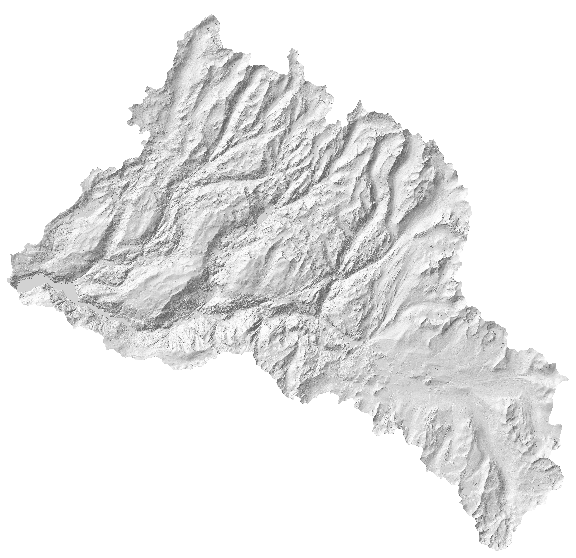

In [41]:
fig = plt.figure(figsize=(15,10))
plt.imshow(terrain.hillshade, cmap='gray', alpha=.6)
# c = plt.contour(ds.dem, levels=levels, colors='dimgray', linewidths=.65, alpha=.9)
# plt.clabel(c, c.levels, inline=True, fontsize=10)
plt.axis('off')
plt.show()

In [4]:
# print('max  value snowdepth [cm]:', ds.snow.values.max())
# print('mean value snowdepth [cm]:', ds.snow.values.mean())

# print('max snow depth [cm]:', np.nanmax(ds.snow.values))
# print('mean snow depth [cm]:', np.nanmean(ds.snow.values))
# print('min snow depth [cm]:', np.nanmin(ds.snow.values))

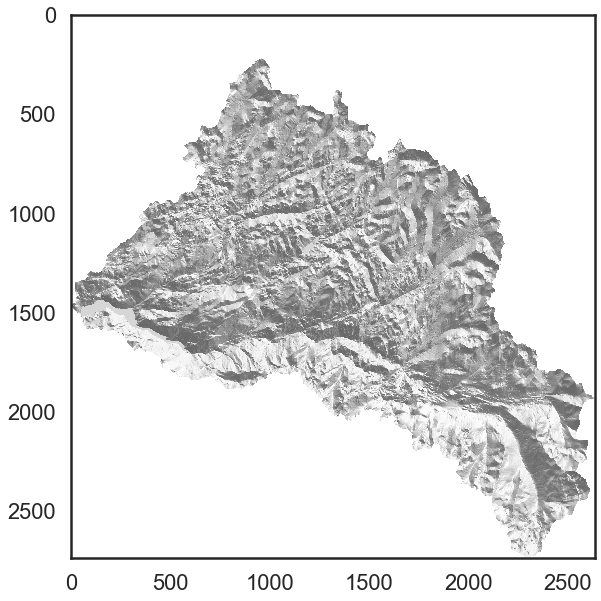

In [20]:
hill = es.hillshade(ds.dem)
levels=[1500,1750,2000,2250,2500,2750,3000,3250,3500,3750]

fig = plt.figure(figsize=(15,10))
plt.imshow(hill, cmap='gray', alpha=.6)
# c = plt.contour(ds.dem, levels=levels, colors='dimgray', linewidths=.65, alpha=.9)
# plt.clabel(c, c.levels, inline=True, fontsize=10)
plt.show()

In [6]:
# compute stats from xarray dataset
x_gt0 = ds.snow.where(ds.snow>0)
mu_gt0 = x_gt0.mean(dim=('x', 'y'))
sig_gt0 = x_gt0.std(dim=('x', 'y'))

#rescaled
rescaled = (x_gt0 / mu_gt0)     #.std(dim='time')
print('RESCALED',rescaled)

#standardize
stdize = ((x_gt0 - mu_gt0) / sig_gt0)
print('\nSTDIZE', stdize)

RESCALED <xarray.DataArray 'snow' (time: 6, y: 17002, x: 17569)>
dask.array<truediv, shape=(6, 17002, 17569), dtype=float64, chunksize=(1, 1000, 1000), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float32 254007.0 254010.0 254013.0 ... 306708.0 306711.0
  * y        (y) float32 4230327.0 4230324.0 4230321.0 ... 4179327.0 4179324.0
  * time     (time) datetime64[ns] 2013-04-03 2014-04-07 ... 2018-04-23
    mask     (y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    dem      (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
    veg      (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan

STDIZE <xarray.DataArray 'snow' (time: 6, y: 17002, x: 17569)>
dask.array<truediv, shape=(6, 17002, 17569), dtype=float64, chunksize=(1, 1000, 1000), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float32 254007.0 254010.0 254013.0 ... 306708.0 306711.0
  * y        (y) float32 4230327.0 4230324.0 4230321.0 ... 4179327.0 4179324.0
  *

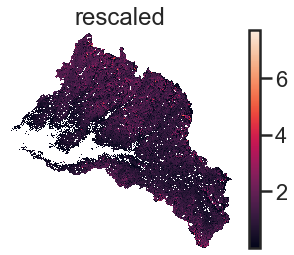

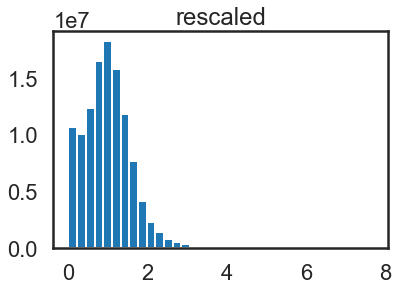

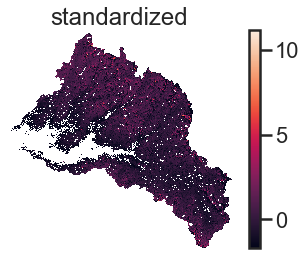

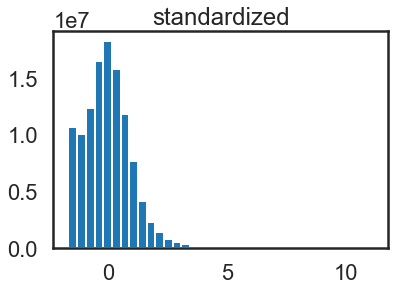

In [7]:
# print('max rescaled: ', np.nanmax(rescaled.values))
# print('mean rescaled: ', np.nanmean(rescaled.values))
plt.imshow(rescaled.isel(time=4))
plt.title('rescaled')
plt.colorbar()
plt.axis('off')
plt.show()

plt.hist(rescaled.isel(time=4).values.flatten(), bins=35)
plt.title('rescaled')
plt.show()

# print('max standardize: ', np.nanmax(stdize.values))
# print('mean standardize: ', np.nanmean(stdize.values))
plt.imshow(stdize.isel(time=4))
plt.title('standardized')
plt.colorbar()
plt.axis('off')
plt.show()

plt.hist(stdize.isel(time=4).values.flatten(), bins=35)
plt.title('standardized')
plt.show()

In [8]:
# get std of standardized dataset

In [9]:
stdize_std_over_time = stdize.std(dim='time') #ssot

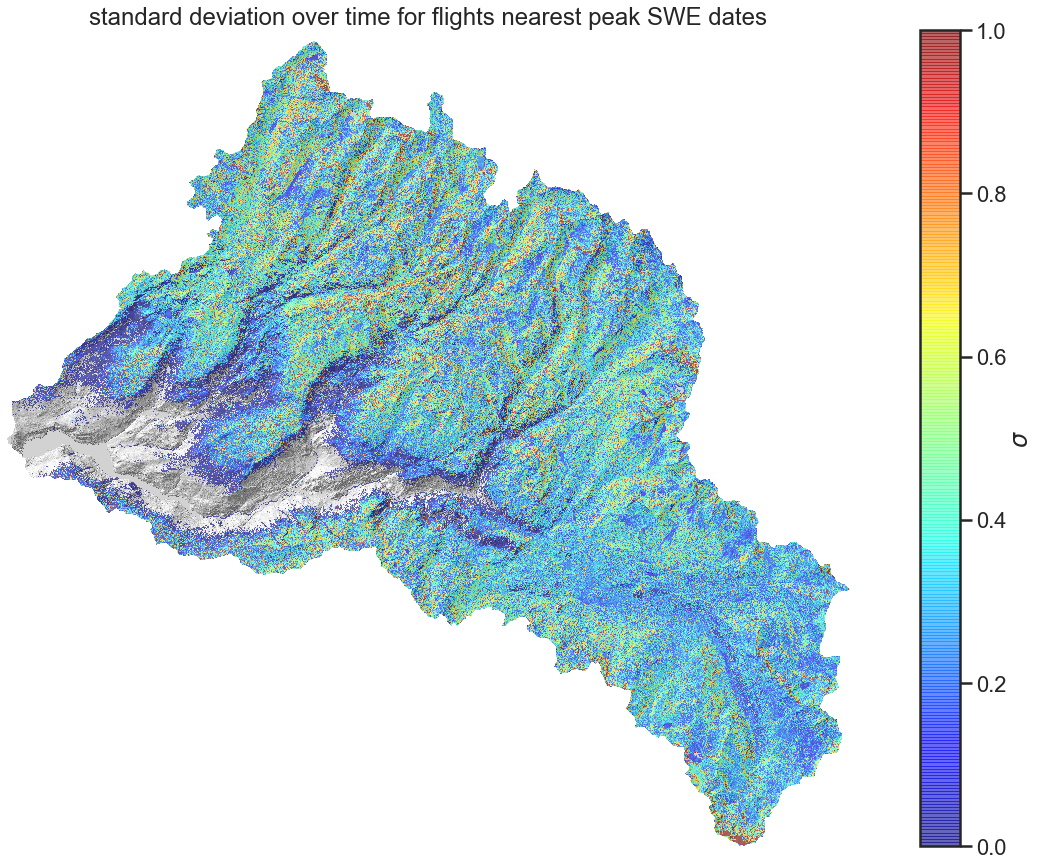

In [43]:
fig= plt.figure(figsize=(25,15))
plt.imshow(terrain.hillshade, cmap='gray', alpha=.6)
# c = plt.contour(ds.dem, levels=levels, colors='dimgray', linewidths=.65, alpha=.9)
# plt.clabel(c, c.levels[:2], inline=True, fontsize=10)

h = plt.imshow(stdize_std_over_time, cmap='jet', alpha=.6, vmax=1.0)
cbar = plt.colorbar(h)
cbar.set_label('$\sigma$')
plt.title('standard deviation over time for flights nearest peak SWE dates', fontsize=fs_titles)
plt.axis('off')
plt.savefig('../figs/stdize_std_peaks', dpi=600, transparent=True)
plt.show()

In [11]:
# a = (ds.snow.where(ds.snow>0) / ds.snow.where(ds.snow>0).mean(dim=('x', 'y')) ).std(dim='time')

In [12]:
# plt.hexbin(ds.dem.values.flatten(),a.isel(time=7).snow.values.flatten(), cmap='Blues')

## other things..

In [13]:
# means=ds.snow.mean(dim=('x', 'y'))
# plt.plot(ds.time, means, marker= 'x')

In [14]:
# yrly_means = ds.snow.groupby('time').mean(dim=('x','y')) # snow values grouped by year, then the mean
# # yrly_means = yrly_means.values.flatten()
# print(yrly_means.values)
# print(yrly_means.shape)

In [15]:
#flatten elevation
# dem_flat = ds.dem.values.flatten()